In [12]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
import numpy as np
import pandas as pd
import tensorflow as tf
from lightgbm import LGBMClassifier
import matplotlib.pyplot as plt
from keras.layers import Activation, Dense, Dropout, BatchNormalization
from keras.models import Sequential
from keras import optimizers, callbacks
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, log_loss

In [15]:
scaler = MinMaxScaler()
df = df_flg = pd.DataFrame()

def parameters():
  params = ['open', 'close', 'high', 'low', 'sma5', 'sma7', 'sma10', 'sma20', 'deviation', 'outcome']
  requisite = ['open', 'close', 'high', 'low']
  past_dates = 5
  for i in range(past_dates):
    for item in requisite:
      params.append(f"{item}_{i+1}")
  print(params)
  return params

for year in range(2022, 2023):
  dir = '/content/drive/MyDrive/datasets/finance/exchange_rate/histdata/test/AAPL_2023_custom_data.csv'
  file_name = f'DAT_MT_USDJPY_1H_{year}.csv'
  # path = dir + file_name
  path = dir
  
  df2 = pd.read_csv(path, index_col=0, parse_dates=True, usecols=lambda column: column!='outcome')
  data = pd.read_csv(path, index_col=0, parse_dates=True)
  data = data[parameters()]
  data = data.dropna()
  df2 = data.drop('outcome', axis=1)
  flg = data[['outcome']]
  print(df2, flg)
  df = pd.concat([df, df2])
  df_flg = pd.concat([df_flg, flg])
  
scaler.fit(df)
df = scaler.transform(df)

x_data = np.array(df)
y_data = np.array(df_flg)

x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.1)


['open', 'close', 'high', 'low', 'sma5', 'sma7', 'sma10', 'sma20', 'deviation', 'outcome', 'open_1', 'close_1', 'high_1', 'low_1', 'open_2', 'close_2', 'high_2', 'low_2', 'open_3', 'close_3', 'high_3', 'low_3', 'open_4', 'close_4', 'high_4', 'low_4', 'open_5', 'close_5', 'high_5', 'low_5']
                           open       close        high         low  \
time                                                                  
2021-03-23 08:00:00  121.226942  121.493396  121.690770  121.147992   
2021-03-23 09:00:00  121.268193  121.799326  122.073675  121.246679   
2021-03-23 10:00:00  121.799326  121.147104  122.065780  120.929105   
2021-03-23 11:00:00  121.143058  121.621689  122.134861  120.990093   
2021-03-23 12:00:00  121.621689  121.562477  122.608558  121.226942   
...                         ...         ...         ...         ...   
2023-03-10 16:00:00  148.660000  148.480000  148.770000  147.609600   
2023-03-10 17:00:00  148.470000  149.080000  149.160000  148.340000   

In [16]:

# model作成
model = LGBMClassifier(num_leaves=31, learning_rate=0.05, n_estimators=20)

evals_result = []
for i, (X_eval, y_eval) in enumerate([(x_train, y_train), (x_test, y_test)]):
    model.fit(X_eval, y_eval, eval_set=[(X_eval, y_eval)], verbose=False)
    y_pred = model.predict_proba(X_eval)
    loss = log_loss(y_eval, y_pred)
    acc = accuracy_score(y_eval, y_pred.argmax(axis=1))
    evals_result.append({'iter': i, 'log_loss': loss, 'accuracy': acc})


/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vec

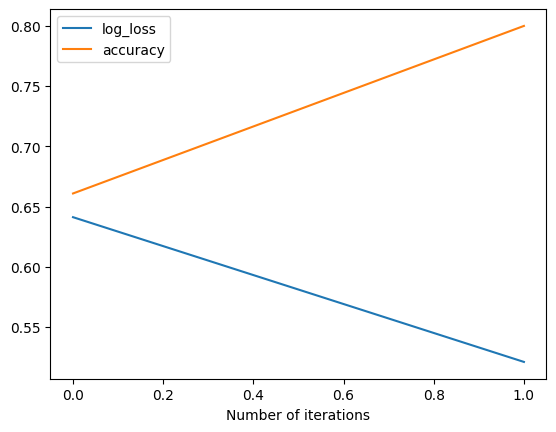

In [17]:
for metric in ['log_loss', 'accuracy']:
    plt.plot([res['iter'] for res in evals_result], [res[metric] for res in evals_result], label=metric)

plt.xlabel('Number of iterations')
plt.legend()
plt.show()

In [18]:
y_pred = model.predict(x_test)

from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)

Accuracy: 0.7997364953886693
